# Incremental Factorization Machines for Item Recommendation in Data Streams

In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp = Runner(dataset='ML1M')

[exp] n_sample = 226310; 67893 (30%) + 45262 (20%) + 113155 (50%)
[exp] n_user = 6014, n_item = 3232


In [4]:
exp_ML100k = Runner(dataset='ML100k')

[exp] n_sample = 21201; 6360 (30%) + 4240 (20%) + 10601 (50%)
[exp] n_user = 928, n_item = 1172


### Plot-related preparation

In [5]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

model_colors = [colors[14], colors[0], colors[4], colors[2], colors[6]]

In [6]:
def plot_setting(fig, ax, head=0, T=5000):
    ax.set_xlabel('sample index', fontsize=11)
    ax.set_ylabel(r'recall@10/%d' % T, fontsize=11)
    ax.yaxis.grid(True)
    ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
    ax.set_ylim([0.0, 0.15])
    
    # 30% pre-train | 70% evaluate
    ax.axvline(x=head, linewidth=1, linestyle=':', color=colors[14])
    
    # head-of-evaluate | first 5000 samples (1st window)
    ax.axvline(x=head+5000-1, linewidth=1, linestyle=':', color=colors[14])
    
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

In [7]:
def show_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
        
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(avgs)), avgs)
    plot_setting(fig, ax)
    
    return avgs, time

In [8]:
def read_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]    
    return avgs, time

## Characteristics of data

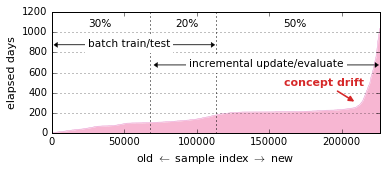

In [9]:
fig, ax = plt.subplots()

ax.plot(exp.data.dts, c=colors[12], lw=.4)
ax.set_xlim((0, exp.data.n_sample-1))
ax.fill_between(np.arange(exp.data.n_sample), np.array(exp.data.dts), facecolor=colors[13], lw=0)

# 30% batch-train | 20% batch-evaluate
ax.arrow(50000, 875, 60000, 0, head_width=50, head_length=2500, fc='k', ec='k', lw=.4)
ax.arrow(50000, 875, -46000, 0, head_width=50, head_length=2500, fc='k', ec='k', lw=.4)
ax.text(25000, 1050, '30%', size=10.5, color='k')
ax.text(25000, 850, 'batch train/test', size=10.5, color='k',
        bbox={'facecolor':'white', 'alpha':1, 'pad':3.2, 'lw': 0})
ax.axvline(x=exp.data.n_batch_train, linewidth=1., linestyle=':', color='k')

ax.text(85000, 1050, '20%', size=10.5, color='k')
ax.axvline(x=(exp.data.n_batch_train + exp.data.n_batch_test), linewidth=1., linestyle=':', color='k')

ax.text(160000, 1050, '50%', size=10.5, color='k')

ax.arrow(130000, 675, 93000, 0, head_width=50, head_length=2500, fc='k', ec='k', lw=.4)
ax.arrow(130000, 675, -57000, 0, head_width=50, head_length=2500, fc='k', ec='k', lw=.4)
ax.text(95000, 650, 'incremental update/evaluate', size=10.5, color='k',
        bbox={'facecolor':'white', 'alpha':1, 'pad':3.2, 'lw': 0})

ax.yaxis.grid(True)
fig.set_size_inches((5.5,2.5))

ax.set_xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
ax.set_ylabel('elapsed days', fontsize=11)

ax.annotate('concept drift', xy=(210000, 300), xytext=(160000, 470), size=11, color=colors[6], fontweight='bold',
            arrowprops=dict(color=colors[6], lw=1.6, arrowstyle='-|>'))

plt.tight_layout()
fig.savefig('../../paper/images/recsys-2016/ml-1m-elapsed-days.eps')

## Monitoring

window size $T=5000$

### ML1M

In [9]:
base5000_avgs, base5000_time = read_result('results/recsys-2016/ML1M/5000/baseline.txt') # epoch=8
iMF5000_avgs, iMF5000_time = read_result('results/recsys-2016/ML1M/5000/iMF.txt') # epoch=8
BiMF5000_avgs, BiMF5000_time = read_result('results/recsys-2016/ML1M/5000/biased-iMF.txt') # epoch=2
iFMs5000_avgs, iFMs5000_time = read_result('results/recsys-2016/ML1M/5000/iFMs_no_context.txt') # epoch=1
iFMs5000_ctx_avgs, iFMs5000_ctx_time = read_result('results/recsys-2016/ML1M/5000/iFMs_context_aware.txt') # epoch=1

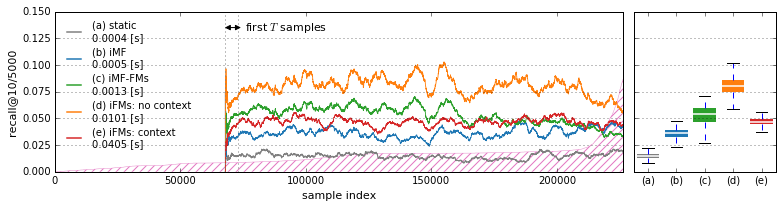

In [10]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 

ax = plt.subplot(gs[0])

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp.data.n_sample-1))
ax2.set_yticks([0, 300, 600, 900, 1200, 1500, 1800])
ax2.set_ylim([0, 1800])
ax2.fill_between(np.arange(exp.data.n_sample), np.array(exp.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
# ax2.set_ylabel('elapsed days')
ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
x = np.arange(len(base5000_avgs))+exp.data.n_batch_train
ax.plot(x, base5000_avgs, c=model_colors[0], label='(a) static\n%.4f [s]' % base5000_time)
ax.plot(x, iMF5000_avgs, c=model_colors[1], lw=.8, label='(b) iMF\n%.4f [s]' % iMF5000_time)
ax.plot(x, BiMF5000_avgs, c=model_colors[2], lw=.8, label='(c) iMF-FMs\n%.4f [s]' % BiMF5000_time)
ax.plot(x, iFMs5000_avgs, c=model_colors[3], lw=.8, label='(d) iFMs: no context\n%.4f [s]' % iFMs5000_time)
ax.plot(x, iFMs5000_ctx_avgs, c=model_colors[4], lw=.8, label='(e) iFMs: context\n%.4f [s]' % iFMs5000_ctx_time)
ax.set_xlim((0, exp.data.n_sample-1))
ax.annotate(r'first $T$ samples', xy=(exp.data.n_batch_train-1000, 0.135), xytext=(exp.data.n_batch_train+8000, 0.1325), size=11, color='k',
            arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp.data.n_batch_train-1)
fig.set_size_inches((11,3.))

leg = ax.legend(fontsize=10, loc='upper left', frameon=False, framealpha=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    
ax_box = plt.subplot(gs[1])
ax_box.yaxis.grid(True)

bp = ax_box.boxplot([base5000_avgs, iMF5000_avgs, BiMF5000_avgs, iFMs5000_avgs, iFMs5000_ctx_avgs], 0, '', widths=0.8, patch_artist=True)

# facecolor
for box, color in zip(bp['boxes'], model_colors):
    box.set(color=color, linewidth=0.)
    
for median in bp['medians']:
    median.set(color='white', linewidth=1.5)
    
ax_box.set_xticklabels(['(a)', '(b)', '(c)', '(d)', '(e)'])
ax_box.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
ax_box.set_yticklabels(['', '', '', '', '', '', ''])
ax_box.set_ylim([0.0, 0.15])

plt.tight_layout()
fig.savefig('../../paper/images/recsys-2016/ml-1m-recall-box.eps')

#### ML100k

In [11]:
ML100k_base_avgs, ML100k_base_time = read_result('results/recsys-2016/ML100k/5000/baseline.txt') # epoch=20
ML100k_iMF_avgs, ML100k_iMF_time = read_result('results/recsys-2016/ML100k/5000/iMF.txt') # epoch=20
ML100k_BiMF_avgs, ML100k_BiMF_time = read_result('results/recsys-2016/ML100k/5000/biased-iMF.txt') # epoch=21
ML100k_iFMs_avgs, ML100k_iFMs_time = read_result('results/recsys-2016/ML100k/5000/iFMs_no_context.txt') # epoch=1
ML100k_iFMs_ctx_avgs, ML100k_iFMs_ctx_time = read_result('results/recsys-2016/ML100k/5000/iFMs_context_aware.txt') # epoch=1

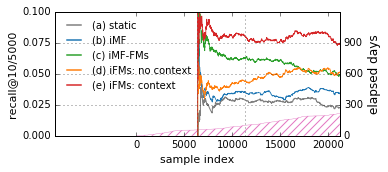

In [12]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp_ML100k.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp_ML100k.data.n_sample-1))
ax2.set_yticks([0, 300, 600, 900])
ax2.set_ylim([0, 1200])
ax2.fill_between(np.arange(exp_ML100k.data.n_sample), np.array(exp_ML100k.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
ax2.set_ylabel('elapsed days')
#ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
x = np.arange(len(ML100k_base_avgs))+exp_ML100k.data.n_batch_train
ax.plot(x, ML100k_base_avgs, c=model_colors[0], label='(a) static')
ax.plot(x, ML100k_iMF_avgs, c=model_colors[1], lw=.8, label='(b) iMF')
ax.plot(x, ML100k_BiMF_avgs, c=model_colors[2], lw=.8, label='(c) iMF-FMs')
ax.plot(x, ML100k_iFMs_avgs, c=model_colors[3], lw=.8, label='(d) iFMs: no context')
ax.plot(x, ML100k_iFMs_ctx_avgs, c=model_colors[4], lw=.8, label='(e) iFMs: context')
ax.set_xlim((-8500, exp_ML100k.data.n_sample-1))
ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp_ML100k.data.n_batch_train-1)
fig.set_size_inches((5.5, 2.5))
ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10])
ax.set_ylim([0.0, 0.10])
    

leg = ax.legend(fontsize=10, loc='upper left', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    
plt.tight_layout()
fig.savefig('../../paper/images/recsys-2016/ml-100k-recall.eps')

## IncrementalRecall-based evaluation

$T=500$

In [13]:
base500_avgs, base500_time = read_result('results/recsys-2016/ML1M/500/baseline.txt')
iMF500_avgs, iMF500_time = read_result('results/recsys-2016/ML1M/500/iMF.txt')
BiMF500_avgs, BiMF_time = read_result('results/recsys-2016/ML1M/500/biased-iMF.txt')
iFMs500_avgs, iFMs500_time = read_result('results/recsys-2016/ML1M/500/iFMs_no_context.txt')
iFMs500_ctx_avgs, iFMs500_ctx_time = read_result('results/recsys-2016/ML1M/500/iFMs_context_aware.txt')

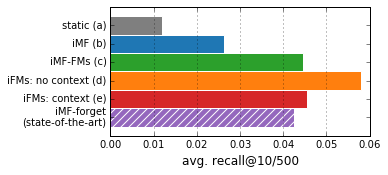

In [14]:
fig, ax = plt.subplots()

N = 1

base = np.array([np.mean(base500_avgs)])
iMF = np.array([np.mean(iMF500_avgs)])
BiMF = np.array([np.mean(BiMF500_avgs)])
iFMs = np.array([np.mean(iFMs500_avgs)])
iFMs_ctx = np.array([np.mean(iFMs500_ctx_avgs)])

forget = np.array([0.0424313423]) #, 0.0424265769])

ind = np.arange(N) / 2.3 + 0.025
width = 0.05

y_pos = np.zeros(6)
for i in range(6):
    y_pos[i] = ind + width * (5 - i)

ax.barh(y_pos[0], base, width, color=model_colors[0], edgecolor='w', label='(a) static')
ax.barh(y_pos[1], iMF, width, color=model_colors[1], edgecolor='w', label='(b) iMF')
ax.barh(y_pos[2], BiMF, width, color=model_colors[2], edgecolor='w', label='(c) iMF-FMs')
ax.barh(y_pos[3], iFMs, width, color=model_colors[3], edgecolor='w', label='(d) iFMs: no context')
ax.barh(y_pos[4], iFMs_ctx, width, color=model_colors[4], edgecolor='w', label='(e) iFMs: context-aware')
ax.barh(y_pos[5], forget, width, color=colors[8], edgecolor='w', label='iMF-forget (state-of-the-art)', hatch='///')

ax.set_xlabel('avg. recall@10/500')

ax.set_yticks(tuple(y_pos + width / 2.))
ax.set_yticklabels(('static (a)', 
                    'iMF (b)', 
                    'iMF-FMs (c)', 
                    'iFMs: no context (d)', 
                    'iFMs: context (e)', 
                    'iMF-forget\n(state-of-the-art)'))

ax.xaxis.grid(True)
# lgd = ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., frameon=False)
# lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0., frameon=False)

fig.set_size_inches((5.5, 2.5))
fig.patch.set_alpha(0.0)

plt.tight_layout()
fig.savefig('../../paper/images/recsys-2016/incremental_recall.eps')